In [1]:
import numpy as np
import yaml
from pprint import pprint
from multiprocessing import shared_memory, Queue, Event
import matplotlib.pyplot as plt

from sturdr.utils.rf_data_buffer import RfDataBuffer
from sturdr.channel.gps_l1ca_channel import GpsL1caChannel

# Load Configuration
config_file = '../config/gps_l1ca_rcvr.yaml'
with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
config['GENERAL']['in_file'] = '../rfdata/class_ifen_8bit_20e6_if_5000445.88565834.bin'
pprint(config)

{'ACQUISITION': {'coherent_integration': 1,
                 'doppler_range': 5000.0,
                 'doppler_step': 250.0,
                 'non_coherent_integration': 5,
                 'threshold': 12.0},
 'CHANNELS': {'max_active_channels': [8], 'signals': ['gps_l1ca']},
 'GENERAL': {'in_file': '../rfdata/class_ifen_8bit_20e6_if_5000445.88565834.bin',
             'max_channels': 12,
             'ms_chunk_size': 100,
             'ms_to_process': 60000,
             'out_folder': 'results',
             'reference_pos_x': 422596.629,
             'reference_pos_y': -5362864.287,
             'reference_pos_z': 3415493.797,
             'scenario': 'GPS_L1CA_TEST'},
 'MEASUREMENTS': {'adr': True,
                  'cn0': True,
                  'doppler': True,
                  'frequency': 1,
                  'pseudorange': True},
 'RFSIGNAL': {'bit_depth': 8,
              'intermediate_freq': 5000445.88565834,
              'is_complex': False,
              'sampling_freq'

In [2]:
# initialize channels
prn = [1, 7, 14, 17, 19, 21, 30]
channel = []
queue = Queue()
rfbuffer = RfDataBuffer(config)
for j in range(len(prn)):
    channel.append(GpsL1caChannel(config, f'Test_GPS{prn[j]}_Channel', rfbuffer, queue, j))
    channel[j].SetSatellite(prn[j])
    channel[j].start()

# initialize output
L = 5000
iq = np.zeros((6, L, len(prn)))
doppler = np.zeros((L, len(prn)))
cn0 = np.zeros((L, len(prn)))

In [3]:
# run loop
for i in range(L):
    # read the next ms of data
    rfbuffer.Push(1)
    
    # inform the channels of new data
    for ch in channel:
        ch.event_start.set()
        
    # wait for the channels to process new data
    for ch in channel:
        ch.event_done.wait()
        ch.event_done.clear()
    
    # process results
    while queue.qsize() > 0:
        packet = queue.get()
        j = packet.ChannelNum
        iq[0,i,j] = packet.IP
        iq[1,i,j] = packet.QP
        doppler[i,j] = packet.Doppler
        cn0[i,j] = packet.CN0

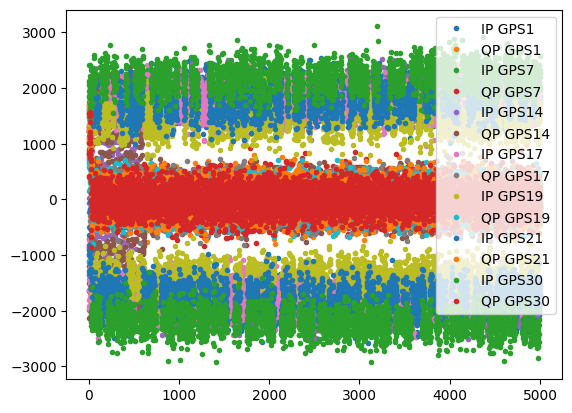

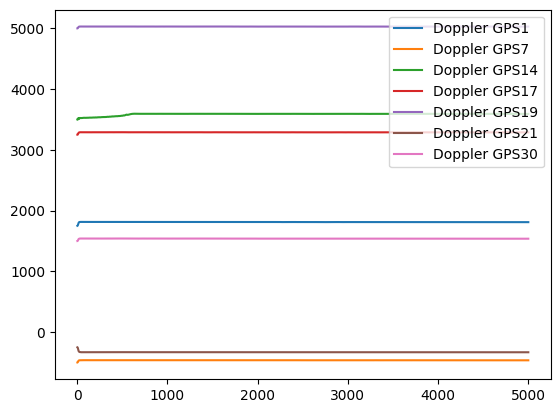

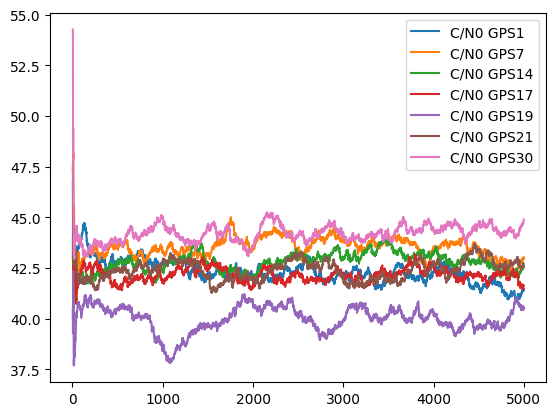

In [4]:
# plot IP and QP
plt.figure()
for j in range(len(prn)):
    plt.plot(iq[0,:,j], '.', label=f'IP GPS{prn[j]}')
    plt.plot(iq[1,:,j], '.', label=f'QP GPS{prn[j]}')
plt.legend()

# plot carrier doppler
plt.figure()
for j in range(len(prn)):
    plt.plot(doppler[:,j], label=f'Doppler GPS{prn[j]}')
plt.legend()

# plot cn0
plt.figure()
for j in range(len(prn)):
    plt.plot(cn0[:,j], label=f'C/N0 GPS{prn[j]}')
plt.legend()

plt.show()